In [42]:
import pandas as pd
import  numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


In [43]:
import plotly.express as px
import plotly.graph_objects as go

In [44]:
!pip install scikit-surprise


In [45]:
from surprise import Dataset, Reader, SVD

In [46]:
from sklearn.model_selection import train_test_split

Data Collection

In [55]:
# Define column names for u.data and load u.data
data_column_names = ['user_id', 'movie_id', 'rating', 'timestamp']
u_data_df = pd.read_csv('u.data', sep='\t', names=data_column_names, engine='python')

# Define columns for u.item file and load the file
item_column_names = [
                     'movie_id', 'movie_title', 'release_date', 'video_release_date', 'imdb_url', 'unknown',
                     'action', 'adventure', 'animation', 'childrens', 'comedy', 'crime', 'documentary',
                     'drama', 'fantasy', 'film_noir', 'horror', 'musical', 'mystery', 'romance',
                     'sci_fi', 'thriller', 'war', 'western'
                     ]
u_item_df = pd.read_csv('u.item', sep='|', names=item_column_names, encoding='latin-1',engine='python')

# load the u.genre file
u_genre_df = pd.read_csv('u.genre', sep='|', names=['genre', 'genre_id'], engine='python')



In [56]:
# Merge user and item datasets on 'movie_id'
merged_df = pd.merge(u_data_df, u_item_df, on='movie_id', how='inner')

merged_df.head()

,user_id,movie_id,rating,timestamp,movie_title,release_date,video_release_date,imdb_url,unknown,action,...,fantasy,film_noir,horror,musical,mystery,romance,sci_fi,thriller,war,western
0,196,242,3,881250949,Kolya (1996),24-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Kolya%20(1996),0,0,...,0,0,0,0,0,0,0,0,0,0
1,63,242,3,875747190,Kolya (1996),24-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Kolya%20(1996),0,0,...,0,0,0,0,0,0,0,0,0,0
2,226,242,5,883888671,Kolya (1996),24-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Kolya%20(1996),0,0,...,0,0,0,0,0,0,0,0,0,0
3,154,242,3,879138235,Kolya (1996),24-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Kolya%20(1996),0,0,...,0,0,0,0,0,0,0,0,0,0
4,306,242,5,876503793,Kolya (1996),24-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Kolya%20(1996),0,0,...,0,0,0,0,0,0,0,0,0,0


In [57]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 27 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   user_id             100000 non-null  int64  
 1   movie_id            100000 non-null  int64  
 2   rating              100000 non-null  int64  
 3   timestamp           100000 non-null  int64  
 4   movie_title         100000 non-null  object 
 5   release_date        99991 non-null   object 
 6   video_release_date  0 non-null       float64
 7   imdb_url            99987 non-null   object 
 8   unknown             100000 non-null  int64  
 9   action              100000 non-null  int64  
 10  adventure           100000 non-null  int64  
 11  animation           100000 non-null  int64  
 12  childrens           100000 non-null  int64  
 13  comedy              100000 non-null  int64  
 14  crime               100000 non-null  int64  
 15  documentary         100000 non-null

In [58]:
#Check for missing values
merged_df.isnull().sum()

,0
user_id,0
movie_id,0
rating,0
timestamp,0
movie_title,0
release_date,9
video_release_date,100000
imdb_url,13
unknown,0
action,0


In [59]:
# Since all values of video release date is null, drop that column
merged_df.drop('video_release_date', axis=1, inplace=True)
#Release date and imdb url has very few missing value. hence remove those columns
merged_df.dropna(inplace=True)

In [60]:
#dropping irrilevent columns
merged_df.drop(['timestamp',  'imdb_url'], axis=1, inplace=True)

In [61]:
#check the duplicates
merged_df.duplicated().sum()

0

In [62]:
merged_df.describe()

,user_id,movie_id,rating,unknown,action,adventure,animation,childrens,comedy,crime,...,fantasy,film_noir,horror,musical,mystery,romance,sci_fi,thriller,war,western
count,99987.000000,99987.000000,99987.000000,99987.000000,99987.000000,99987.000000,99987.000000,99987.000000,99987.000000,99987.00000,...,99987.000000,99987.000000,99987.000000,99987.000000,99987.000000,99987.000000,99987.000000,99987.000000,99987.000000,99987.000000
mean,462.506256,425.507076,3.529929,0.000010,0.255903,0.137548,0.036055,0.071829,0.298359,0.08056,...,0.013522,0.017332,0.053177,0.049546,0.052457,0.194635,0.127317,0.218748,0.093992,0.018542
std,266.613847,330.763806,1.125606,0.003162,0.436370,0.344427,0.186427,0.258206,0.457540,0.27216,...,0.115495,0.130507,0.224387,0.217007,0.222948,0.395922,0.333329,0.413400,0.291819,0.134903
min,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,254.000000,175.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,447.000000,322.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,682.000000,631.000000,4.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,943.000000,1682.000000,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


**EDA**

Movies with highest number of ratings

In [63]:
# Create a dataset to explore
eda_rating = pd.DataFrame(merged_df.groupby('movie_title')['rating'].mean())
eda_rating['count of ratings'] = pd.DataFrame(merged_df.groupby('movie_title')['rating'].count())
eda_rating.head()
eda_rating.sort_values('count of ratings', ascending=False).head(10)

,rating,count of ratings
movie_title,,
Star Wars (1977),4.358491,583
Contact (1997),3.803536,509
Fargo (1996),4.155512,508
Return of the Jedi (1983),4.007890,507
Liar Liar (1997),3.156701,485
"English Patient, The (1996)",3.656965,481
Scream (1996),3.441423,478
Toy Story (1995),3.878319,452
Air Force One (1997),3.631090,431


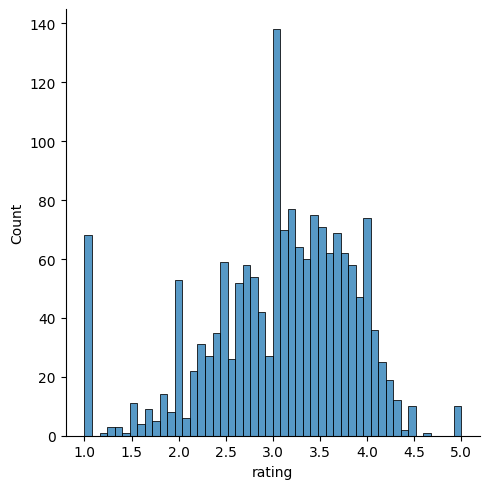

In [64]:
import seaborn as sns
sns.displot(data=eda_rating, x='rating', bins=50)

In [65]:
#Threashold for minimum number of movies set as 60 and sort by rating
popular_movie_list_with_rating= eda_rating[eda_rating['count of ratings'] > 100].sort_values('rating', ascending=False)
popular_movie_list_with_rating

,rating,count of ratings
movie_title,,
"Close Shave, A (1995)",4.491071,112
Schindler's List (1993),4.466443,298
"Wrong Trousers, The (1993)",4.466102,118
Casablanca (1942),4.456790,243
"Shawshank Redemption, The (1994)",4.445230,283
...,...,...
Spawn (1997),2.615385,143
Event Horizon (1997),2.574803,127
Crash (1996),2.546875,128


In [66]:
# Sort by count of rating and then by average rating
popular_movie_list = popular_movie_list_with_rating.sort_values([ 'count of ratings','rating'], ascending=False)
popular_movie_list

,rating,count of ratings
movie_title,,
Star Wars (1977),4.358491,583
Contact (1997),3.803536,509
Fargo (1996),4.155512,508
Return of the Jedi (1983),4.007890,507
Liar Liar (1997),3.156701,485
...,...,...
"Sex, Lies, and Videotape (1989)",3.475248,101
Basic Instinct (1992),3.227723,101
Young Guns (1988),3.207921,101


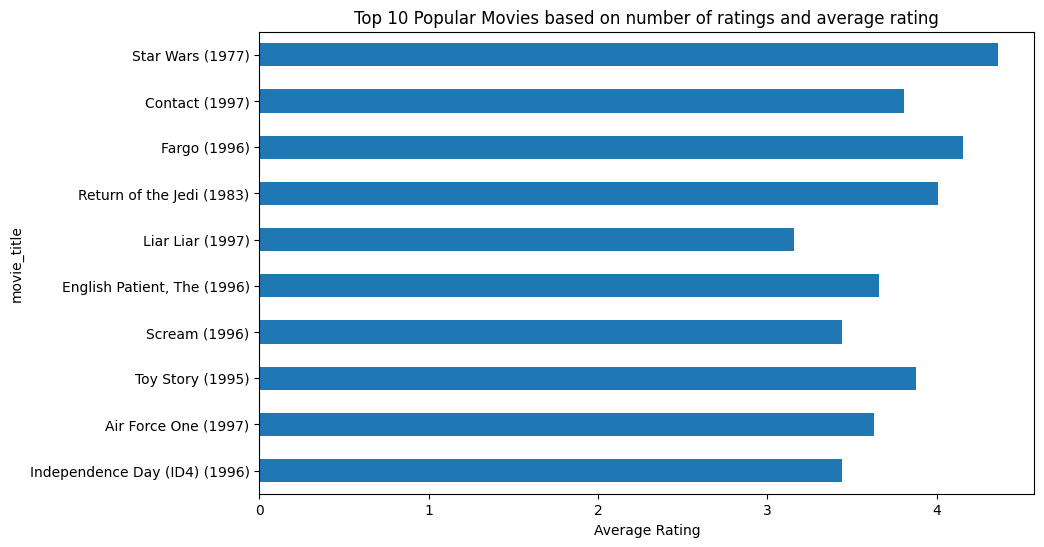

In [67]:
#Plotting top 10 popular movies
top_movies= popular_movie_list.head(10)
top_movies['rating'].plot(kind='barh', figsize=(10, 6))
plt.title('Top 10 Popular Movies based on number of ratings and average rating')
plt.xlabel('Average Rating')
plt.gca().invert_yaxis()  # To display the highest rated movie at the top
plt.show()

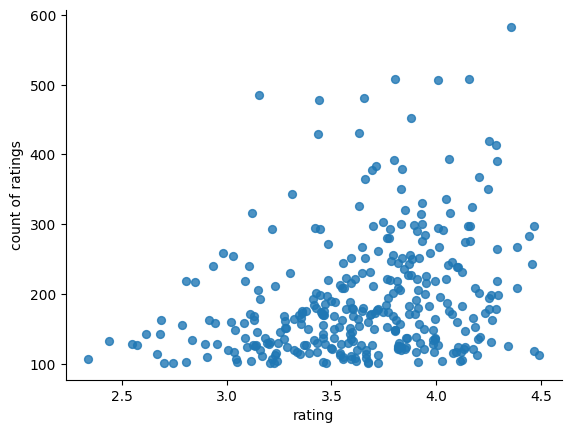

In [68]:
# @title rating vs count of ratings

from matplotlib import pyplot as plt
popular_movie_list.plot(kind='scatter', x='rating', y='count of ratings', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

In [74]:
#Movie count by genre
genre_columns = ['unknown', 'action', 'adventure', 'animation', 'childrens', 'comedy', 'crime',
                 'documentary', 'drama', 'fantasy', 'film_noir', 'horror', 'musical', 'mystery',
                 'romance', 'sci_fi', 'thriller', 'war', 'western']
genre_counts = merged_df[genre_columns].sum()
print(genre_counts)
fig = px.bar(
    genre_counts,
    x=genre_counts.index,
    y=genre_counts.values,
    labels={'x': 'Movie Genre', 'y': 'Count'},
    title='Counts of Each Movie Category'
)

# Update the layout for better appearance
fig.update_layout(
    xaxis_title='Movie Genre',
    yaxis_title='Count',
    xaxis_tickangle=-45
)

# Show the plot
fig.show()

unknown            1
action         25587
adventure      13753
animation       3605
childrens       7182
comedy         29832
crime           8055
documentary      758
drama          39893
fantasy         1352
film_noir       1733
horror          5317
musical         4954
mystery         5245
romance        19461
sci_fi         12730
thriller       21872
war             9398
western         1854
dtype: int64


##Matrix Factorization

Displaying the user-item sparse matrix

In [76]:
mtrx_df = u_data_df.pivot(index = 'user_id', columns ='movie_id', values = 'rating').fillna(0)
mtrx_df.head()

movie_id,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
user_id,,,,,,,,,,,,,,,,,,,,,
1,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


 Demeaning involves subtracting the mean rating for each user from their ratings. This centers the data around zero for each user, effectively removing individual biases. Some users may consistently rate higher or lower than others, and centering helps account for these tendencies.

In [77]:
# Demean the data
mtrx = mtrx_df.to_numpy()
ratings_mean = np.mean(mtrx, axis = 1)
normalized_mtrx = mtrx - ratings_mean.reshape(-1, 1)

Decomposing the matrix into user vectors and item vectors.

In [81]:

from scipy.sparse.linalg import svds

In [82]:
# Singular value decomposition
U, sigma, Vt = svds(normalized_mtrx, k = 50)

U: A matrix where each row represents a user in terms of latent factors.

sigma: A vector containing the top k singular values.

Vt: A matrix where each column represents an item in terms of latent factors

## Product-wise Multiplication for each user-movie pairs


In [83]:
# Convert to diagonal form
sigma = np.diag(sigma)
# Make predictions for any user
all_predicted_ratings = np.dot(np.dot(U, sigma), Vt) + ratings_mean.reshape(-1, 1)
preds_df = pd.DataFrame(all_predicted_ratings, columns = mtrx_df.columns)
preds_df.head()

movie_id,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
0,6.488436,2.959503,1.634987,3.024467,1.656526,1.659506,3.630469,0.240669,1.791518,3.347816,...,0.011976,-0.092017,-0.074553,-0.060985,0.009427,-0.035641,-0.039227,-0.037434,-0.025552,0.023513
1,2.347262,0.129689,-0.098917,0.328828,0.159517,0.481361,0.213002,0.097908,1.892100,0.671000,...,0.003943,-0.026939,-0.035460,-0.029883,-0.027153,-0.015244,-0.008277,-0.011760,0.011639,-0.046924
2,0.291905,-0.263830,-0.151454,-0.179289,0.013462,-0.088309,-0.057624,0.568764,-0.018506,0.280742,...,-0.028964,-0.031622,0.045513,0.026089,-0.021705,0.002282,0.032363,0.017322,-0.006644,-0.009480
3,0.366410,-0.443535,0.041151,-0.007616,0.055373,-0.080352,0.299015,-0.010882,-0.160888,-0.118834,...,0.020069,0.015981,-0.000182,0.005593,0.026634,0.023562,0.036405,0.029984,0.015612,-0.008713
4,4.263488,1.937122,0.052529,1.049350,0.652765,0.002836,1.730461,0.870584,0.341027,0.569055,...,0.019973,-0.053521,-0.017242,-0.007137,-0.038987,0.010338,0.004869,0.007603,-0.020575,0.003330


In [84]:
def recommend_movies(preds_df, user_id, movie, ratings_df, num_recommendations=5):
    #Since index starts from zero, to get user row number
    user_row_number = user_id-1
    # Sort user's predictons
    sorted_user_predictions = preds_df.iloc[user_row_number].sort_values(ascending=False)
    # List movies user already rated
    user_data = ratings_df[ratings_df.user_id == (user_id)]
    user_rated = (user_data.merge(movie, how = 'left', left_on = 'movie_id', right_on = 'movie_id').
                  sort_values(['rating'], ascending=False)
                 )
    recommendations = (movie[~movie['movie_id'].isin(user_rated['movie_id'])].
         merge(pd.DataFrame(sorted_user_predictions).reset_index(), how = 'left',
               left_on = 'movie_id',
               right_on = 'movie_id').
               rename(columns = {user_row_number: 'Predictions'}).
               sort_values('Predictions', ascending = False).
               iloc[:num_recommendations, :-1]
                      )

    return user_rated, recommendations

## Evaluation for Matrix Factorization

In [85]:
from sklearn.metrics import mean_squared_error
import numpy as np

latent_sizes = [20, 30, 40, 50]
rmses = []

for k in latent_sizes:
    # Demean the data
    mtrx = mtrx_df.to_numpy()
    ratings_mean = np.mean(mtrx, axis=1)
    normalized_mtrx = mtrx - ratings_mean.reshape(-1, 1)

    # Perform Singular Value Decomposition
    U, sigma, Vt = svds(normalized_mtrx, k=k)
    sigma = np.diag(sigma)

    # Make predictions
    all_predicted_ratings = np.dot(np.dot(U, sigma), Vt) + ratings_mean.reshape(-1, 1)
    preds_df = pd.DataFrame(all_predicted_ratings, columns=mtrx_df.columns)

    # Calculate RMSE
    true_ratings = mtrx_df.to_numpy().flatten()
    pred_ratings = preds_df.to_numpy().flatten()
    rmse = np.sqrt(mean_squared_error(true_ratings, pred_ratings))
    rmses.append(rmse)

# Save RMSEs
results_df = pd.DataFrame({'Latent Size': latent_sizes, 'RMSE': rmses})
results_df.to_csv('latent_size_rmse.csv', index=False)

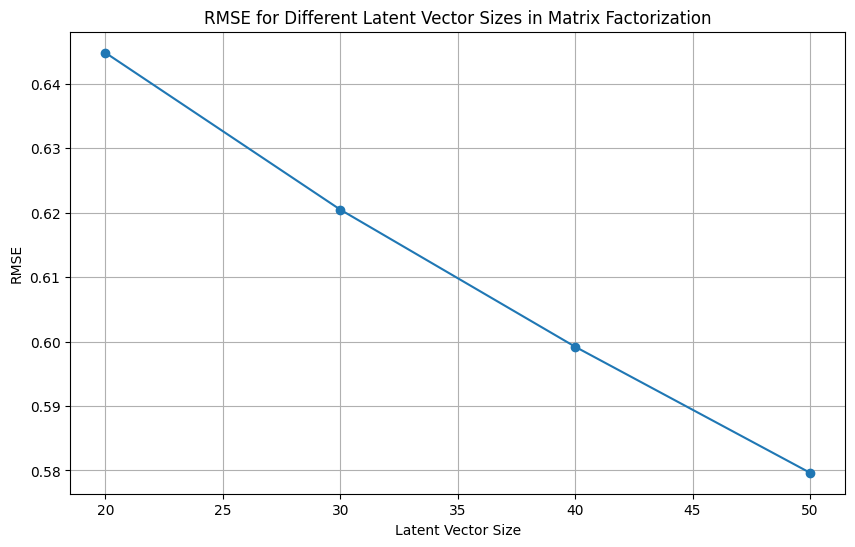

In [86]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(latent_sizes, rmses, marker='o')
plt.xlabel('Latent Vector Size')
plt.ylabel('RMSE')
plt.title('RMSE for Different Latent Vector Sizes in Matrix Factorization')
plt.grid(True)
plt.savefig('latent_size_rmse.png')
plt.show()

In [87]:
#for random user_id 100
already_rated, predictions = recommend_movies(preds_df, 100,u_item_df, u_data_df, 10)

In [88]:
already_rated.head(10)

,user_id,movie_id,rating,timestamp,movie_title,release_date,video_release_date,imdb_url,unknown,action,...,fantasy,film_noir,horror,musical,mystery,romance,sci_fi,thriller,war,western
58,100,315,5,891375557,Apt Pupil (1998),23-Oct-1998,NaN,http://us.imdb.com/Title?Apt+Pupil+(1998),0,0,...,0,0,0,0,0,0,0,1,0,0
14,100,316,5,891375313,As Good As It Gets (1997),23-Dec-1997,NaN,http://us.imdb.com/Title?As+Good+As+It+Gets+(1...,0,0,...,0,0,0,0,0,0,0,0,0,0
22,100,313,5,891374706,Titanic (1997),01-Jan-1997,NaN,http://us.imdb.com/M/title-exact?imdb-title-12...,0,1,...,0,0,0,0,0,1,0,0,0,0
55,100,751,4,891374868,Tomorrow Never Dies (1997),01-Jan-1997,NaN,http://us.imdb.com/M/title-exact?imdb-title-12...,0,1,...,0,0,0,0,0,1,0,1,0,0
48,100,272,4,891375629,Good Will Hunting (1997),01-Jan-1997,NaN,http://us.imdb.com/M/title-exact?imdb-title-11...,0,0,...,0,0,0,0,0,0,0,0,0,0
47,100,294,4,891375313,Liar Liar (1997),21-Mar-1997,NaN,http://us.imdb.com/Title?Liar+Liar+(1997),0,0,...,0,0,0,0,0,0,0,0,0,0
45,100,900,4,891374832,Kundun (1997),25-Dec-1997,NaN,http://us.imdb.com/M/title-exact?imdb-title-11...,0,0,...,0,0,0,0,0,0,0,0,0,0
44,100,258,4,891374675,Contact (1997),11-Jul-1997,NaN,http://us.imdb.com/Title?Contact+(1997/I),0,0,...,0,0,0,0,0,0,1,0,0,0
19,100,752,4,891375146,"Replacement Killers, The (1998)",06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?Replacement+K...,0,1,...,0,0,0,0,0,0,0,1,0,0
38,100,347,4,891375212,Wag the Dog (1997),09-Jan-1998,NaN,http://us.imdb.com/M/title-exact?imdb-title-12...,0,0,...,0,0,0,0,0,0,0,0,0,0


In [89]:
predictions

,movie_id,movie_title,release_date,video_release_date,imdb_url,unknown,action,adventure,animation,childrens,...,fantasy,film_noir,horror,musical,mystery,romance,sci_fi,thriller,war,western
292,307,"Devil's Advocate, The (1997)",01-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Devil's+Advoc...,0,0,0,0,0,...,0,0,1,0,1,0,0,1,0,0
287,301,In & Out (1997),19-Sep-1997,NaN,http://us.imdb.com/Title?In+%26+Out+(1997),0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
308,331,"Edge, The (1997)",26-Sep-1997,NaN,http://us.imdb.com/M/title-exact?Edge%2C+The+(...,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
711,748,"Saint, The (1997)",14-Mar-1997,NaN,http://us.imdb.com/M/title-exact?Saint%2C%20Th...,0,1,0,0,0,...,0,0,0,0,0,1,0,1,0,0
309,332,Kiss the Girls (1997),01-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Kiss+the+Girl...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
317,343,Alien: Resurrection (1997),01-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Alien%3A+Resu...,0,1,0,0,0,...,0,0,1,0,0,0,1,0,0,0
244,245,"Devil's Own, The (1997)",26-Mar-1997,NaN,http://us.imdb.com/M/title-exact?Devil%27s%20O...,0,1,0,0,0,...,0,0,0,0,0,0,0,1,1,0
296,312,Midnight in the Garden of Good and Evil (1997),01-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Midnight+in+t...,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
305,327,Cop Land (1997),01-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Cop+Land+(1997),0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
289,304,Fly Away Home (1996),13-Sep-1996,NaN,http://us.imdb.com/M/title-exact?Fly%20Away%20...,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
